In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats


In [ ]:
# Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров 
# (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).
# У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема, к вечеру скорость 
# доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. 
# Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 
# Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед 
# окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. 
# То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 
# Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. 
# Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. 
# Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

In [2]:
df = pd.read_csv('/home/jupyter-s.volosjuk-15/STATISTICS/experiment_lesson_4.csv')

In [3]:
df.head()

order_id  delivery_time  district experiment_group
0      3159           44.0  Purlieus          control
1     10426           51.0  Purlieus          control
2      9155           46.0  Purlieus          control
3     10699           34.0  Purlieus          control
4     10061           43.0  Purlieus          control

In [6]:
df.shape

(20196, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [8]:
df.district.value_counts()

Purlieus    16960
Central      2396
Suburb        840
Name: district, dtype: int64

In [10]:
# Для начала давайте сформулируем гипотезы , которые мы сможем проверить в этом эксперименте:
# Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
# Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

In [17]:
control_df = df.query('experiment_group == "control"')
test_df = df.query('experiment_group == "test"')

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

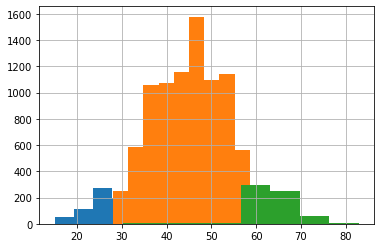

In [24]:
df.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

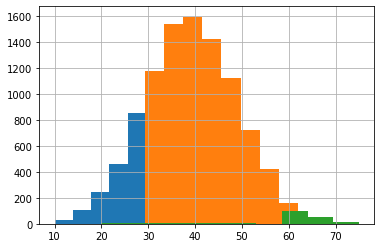

In [25]:
df.query('experiment_group == "test"').groupby('district').delivery_time.hist()

In [26]:
# Посчитайте количество наблюдений в тестовой и контрольной группе. 
# На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [54]:
abs(control_df.shape[0] - test_df.shape[0])

12

In [30]:
# Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение 
# в тесте и в контроле.
# Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), 
# так как на больших выборках вы можете получать неверные результаты: 

In [38]:
stats.shapiro(test_df.delivery_time.sample(1000, random_state=17)) # p > 0.05 - Н0 - не отклоняем, распределение - нормальное

(0.9975479245185852, 0.14013493061065674)

In [39]:
stats.shapiro(control_df.delivery_time.sample(1000, random_state=17)) # p > 0.05 - Н0 - не отклоняем, распределение - нормальное

(0.9974725842475891, 0.12411931157112122)

In [40]:
test_df.delivery_time.std() # Стандартное отклонение времени доставки в тесте

9.883308351129061

In [41]:
control_df.delivery_time.std() # Стандартное отклонение времени доставки в контроле 

9.990016960246372

In [42]:
# Пришло время сравнить средние в тесте и контроле.

In [45]:
stats.ttest_ind(test_df.delivery_time, control_df.delivery_time) # p-value < 0.05 - H0 - отвергаем

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [46]:
# На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

In [47]:
test_df.delivery_time.mean()

39.04681314330958

In [48]:
control_df.delivery_time.mean()

45.065101070154576

In [49]:
round(((test_df.delivery_time.mean() - control_df.delivery_time.mean()) / control_df.delivery_time.mean() * 100), 2)

-13.35

In [50]:
# Что в итоге? Катим?

# Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. 
# Среднее время доставки в тесте меньше, чем в контроле.